Dataset from https://www.physionet.org/content/eegmmidb/1.0.0/

In [461]:
import pandas as pd

In [462]:
import mne

In [463]:
import numpy as np

In [464]:
%matplotlib inline
import matplotlib.pyplot as plt

In [465]:
from pylab import rcParams

In [466]:
from mne.stats import permutation_cluster_1samp_test as pcluster_test
from mne.viz.utils import center_cmap

In [467]:
eeg = mne.io.read_raw_edf(
    "./S001R03.edf", 
    preload=True,
    exclude=["T9..", "T10."]
)

Extracting EDF parameters from /home/noomkcalb/Документы/neuroscience/right-left/S001R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...


In [468]:
eeg.rename_channels(lambda x: x.strip('.'))

# Simple EEG visualization

In [531]:
start = 9
stop = 16
start_index, stop_index = eeg.time_as_index([start, stop])
channel_pick = mne.pick_channels(eeg.info["ch_names"], ["C3", "Cz", "C4"])
data, times = eeg[channel_pick, start_index:stop_index]

In [532]:
np.save("./real-time/tests/test_data.npy", data)

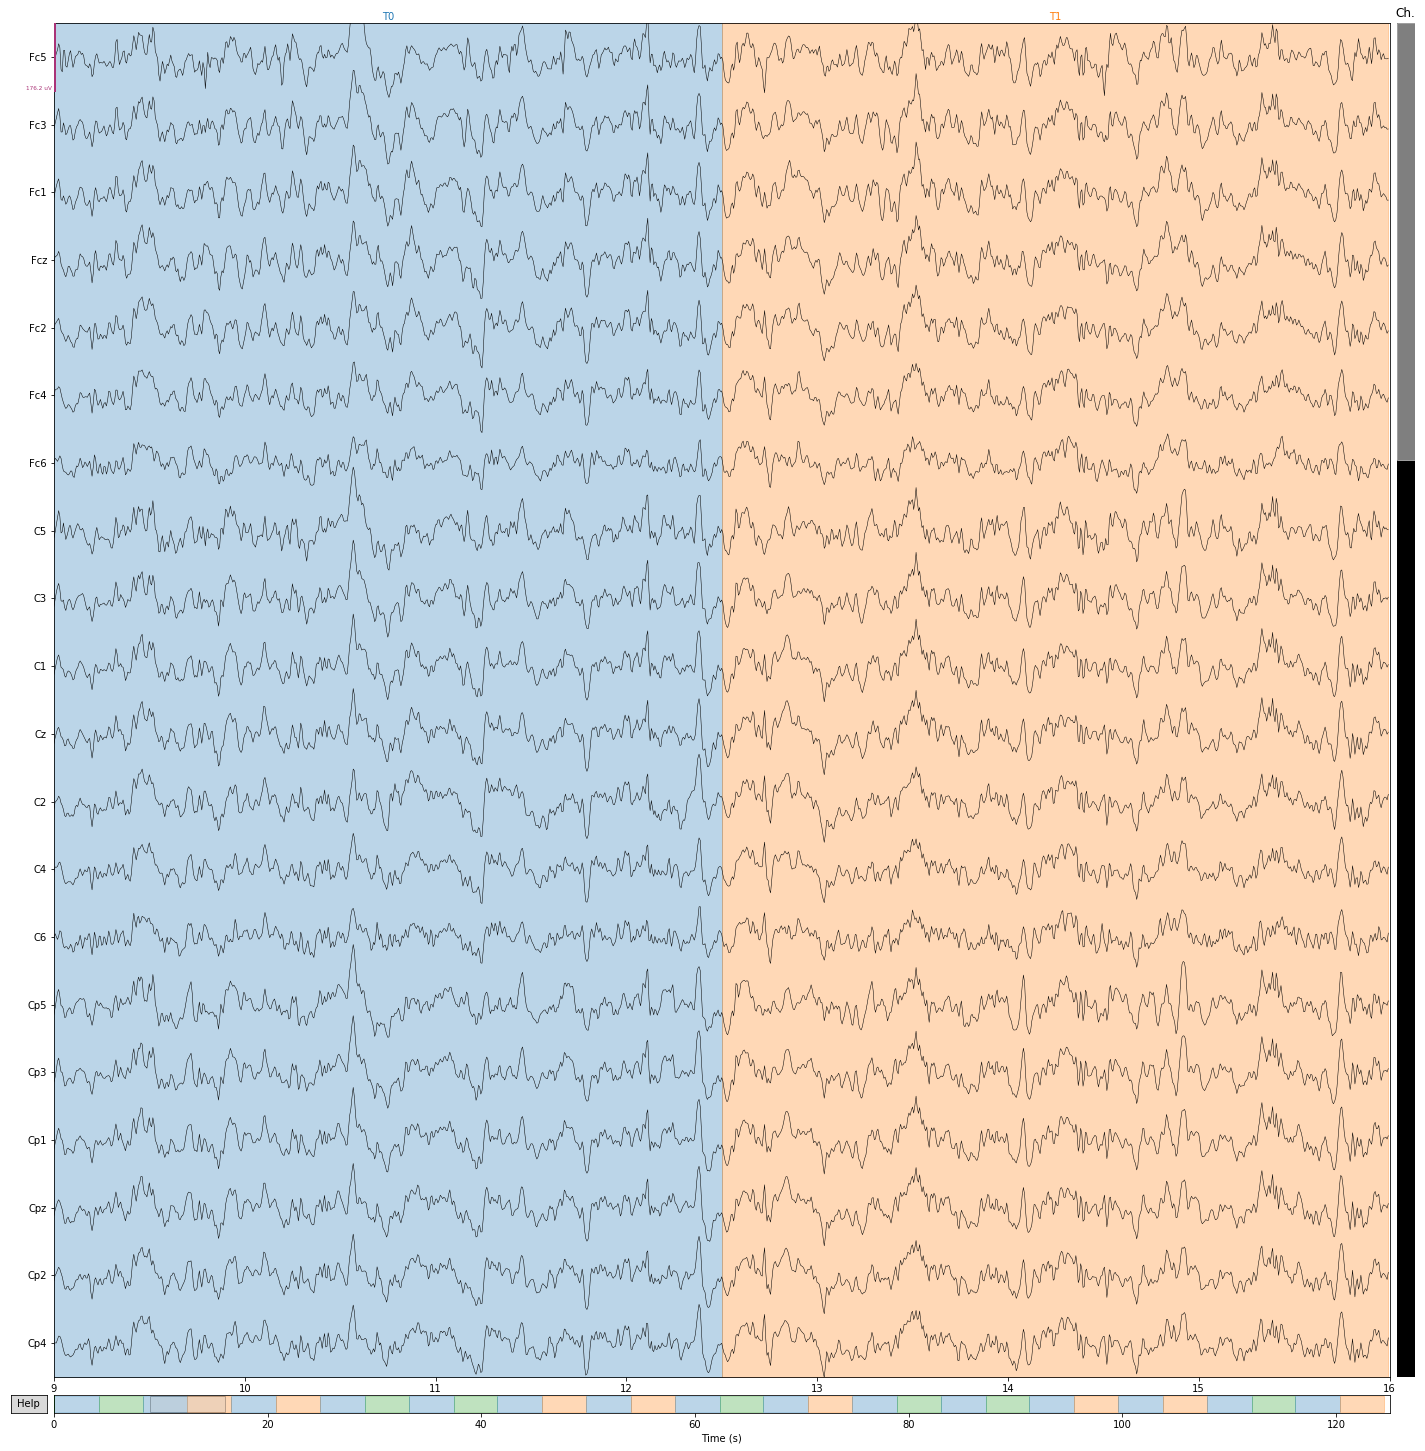

In [533]:
rcParams['figure.figsize'] = 20, 20
mne.viz.plot_raw(
    eeg, 
    start=start, 
    duration=stop - start, 
    show=True, 
    scalings={"eeg": np.percentile(np.abs(data), 99)}
)
plt.show()

# Epochs definition

- T0 corresponds to rest
- T1 corresponds to onset of motion (real or imagined) of
    - the left fist (in runs 3, 4, 7, 8, 11, and 12)
    - both fists (in runs 5, 6, 9, 10, 13, and 14)
- T2 corresponds to onset of motion (real or imagined) of
    - the right fist (in runs 3, 4, 7, 8, 11, and 12)
    - both feet (in runs 5, 6, 9, 10, 13, and 14)

In [534]:
eeg.annotations

<Annotations  |  30 segments : T2 (7), T0 (15), T1 (8), orig_time : 2009-08-12 16:15:00>

# Filtered signal

In [535]:
eeg.filter(2, 50)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)



<RawEDF  |  S001R03.edf, n_channels x n_times : 62 x 20000 (125.0 sec), ~9.6 MB, data loaded>

In [572]:
events, annot_to_events = mne.events_from_annotations(eeg)
print(events[:5])

Used Annotations descriptions: ['T2', 'T0', 'T1']
[[   0    0    1]
 [ 672    0    3]
 [1328    0    1]
 [2000    0    2]
 [2656    0    1]]


In [573]:
annot_to_events

{'T0': 1, 'T1': 2, 'T2': 3}

In [574]:
tmin = -4
tmax = 3

In [575]:
picks = mne.pick_channels(eeg.info["ch_names"], ["C3", "Cz", "C4"])

In [600]:
picks

array([ 8, 10, 12])

In [601]:
epochs = mne.Epochs(
    eeg, 
    events, 
    event_id={
        "none": 1,
        "left": 2,
        "right": 3
    },
    tmin=tmin - 0.5,
    tmax=tmax + 0.5,
    picks=picks,
    preload=True,
#     baseline!
)
print(epochs)

30 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 30 events and 1281 original time points ...
2 bad epochs dropped
<Epochs  |   28 events (all good), -4.5 - 3.5 sec, baseline [None, 0], ~853 kB, data loaded,
 'left': 8
 'none': 14
 'right': 6>


In [602]:
# epochs.drop([i for i, j in enumerate(epochs.selection) if (i % 2 != 0) and (i > 1)])

# Averaged signal

In [603]:
# epochs['right'].average().plot(show=False)
# plt.plot()

[]

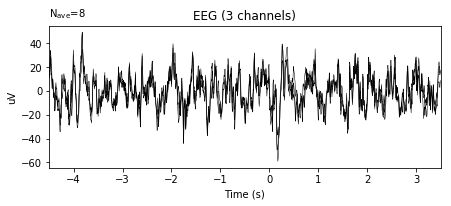

In [604]:
epochs['left'].average().plot(show=False)
plt.plot()

[]

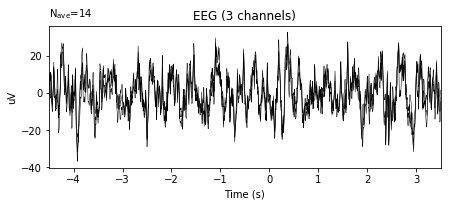

In [605]:
epochs['none'].average().plot(show=False)
plt.plot()

# Time-frequency analysis

In [606]:
freqs = np.arange(7, 45, 1)  # frequencies of interest
n_cycles = freqs  # number of cycles in Morlet wavelet

In [672]:
def draw_power(event, baseline=[-1, 0], mask=None):
    rcParams['figure.figsize'] = 21, 3
    erds = {}
    for i, channel in enumerate(["C3", "Cz", "C4"]):
        plt.subplot(130 + i + 1)
        power, itc = mne.time_frequency.tfr_multitaper(
            epochs[event], 
            freqs=freqs, 
            n_cycles=n_cycles,
            return_itc=True, 
            decim=3, 
            n_jobs=1,
            picks=[channel]
        )
        power.apply_baseline(baseline, mode='percent')
        power.crop(-1, tmax)
        power.plot(
            show=False, 
            axes=plt.gca(),
            vmin=-2,
            vmax=2,
            mask=mask
        )
        plt.title(channel)
        plt.axvline(0)
        plt.axhline(6)
        plt.axhline(10)
        plt.axhline(14)
        plt.axhline(16)
        plt.axhline(26)
        plt.axhline(35)
        erds[channel] = power
    return erds

Как по известному спектру можно классифицировать попытку?
- 

Applying baseline correction (mode: percent)
No baseline correction applied
Applying baseline correction (mode: percent)
No baseline correction applied
Applying baseline correction (mode: percent)
No baseline correction applied


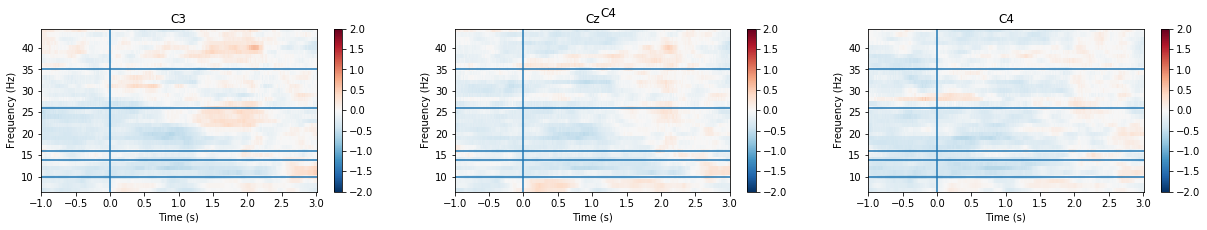

In [716]:
p = draw_power("right", [-1, 0])

No baseline correction applied


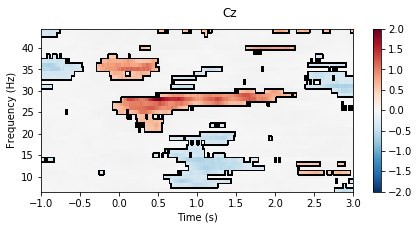

In [712]:
plt.figure(figsize=(7, 3))
p["Cz"].plot(
    show=False, 
    vmin=-2,
    vmax=2,
    mask=np.squeeze((p["Cz"].data > 0.5) | (p["Cz"].data < -0.3)),
    axes=plt.gca(),
)
plt.show()

(array([ 111.,  410., 1328., 1853., 1709., 1565.,  744.,  333.,   69.,
          10.]),
 array([-0.52854537, -0.42788139, -0.32721741, -0.22655344, -0.12588946,
        -0.02522548,  0.0754385 ,  0.17610248,  0.27676646,  0.37743044,
         0.47809442]),
 <a list of 10 Patch objects>)

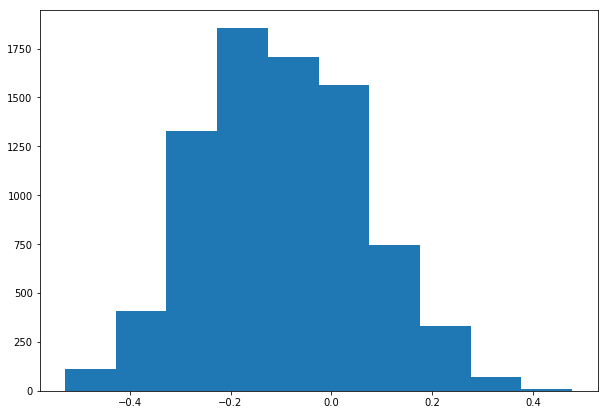

In [717]:
plt.figure(figsize=(10, 7))
plt.hist(p["Cz"].data.reshape(-1))

In [690]:
np.squeeze((p["Cz"].data > 1) | (p["Cz"].data < -1))

0

In [669]:
p.data.shape

TypeError: unorderable types: tuple() > int()

Applying baseline correction (mode: percent)
No baseline correction applied
Applying baseline correction (mode: percent)
No baseline correction applied
Applying baseline correction (mode: percent)
No baseline correction applied


<AverageTFR  |  time : [-0.993750, 3.000000], freq : [7.000000, 44.000000], nave : 8, channels : 1, ~72 kB>

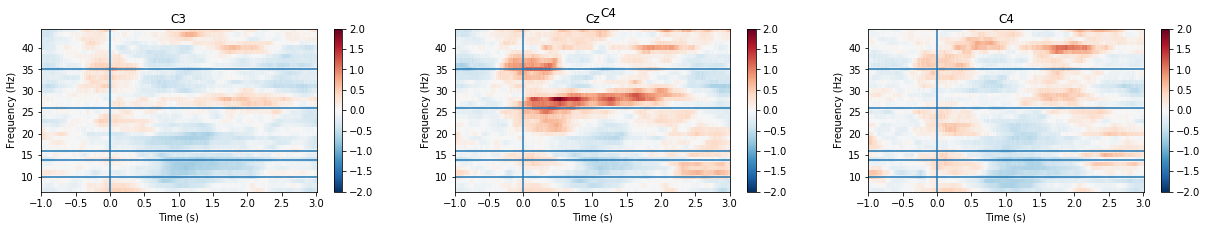

In [664]:
draw_power("left",  [-1, 0])

Applying baseline correction (mode: percent)
No baseline correction applied
Applying baseline correction (mode: percent)
No baseline correction applied
Applying baseline correction (mode: percent)
No baseline correction applied


<AverageTFR  |  time : [-0.993750, 3.000000], freq : [7.000000, 44.000000], nave : 14, channels : 1, ~72 kB>

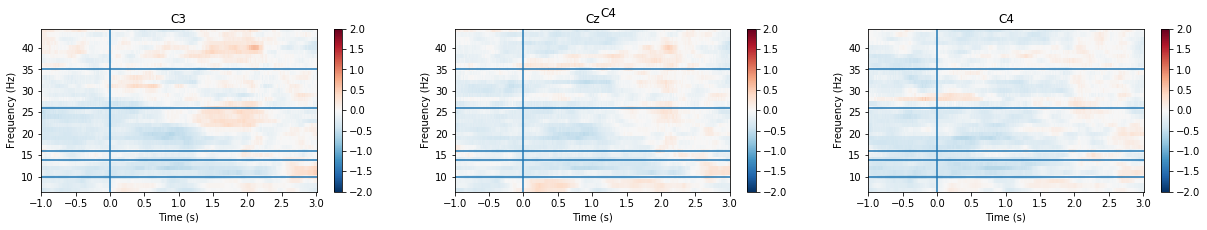

In [665]:
draw_power("none", [2, 3])

- Beta ERS
- Gamma ERS
- Low alpha ERD

Spectral effects:
- Lower alpha ERD (6-10 Hz) - all tasks
- Higher alpha ERD (10-14 Hz) - visual stim
- Beta ERS (16-21, 19-26) right after the movement, about 600ms
- Gamma ERS (35-45 Hz) after the stim and before the movement, 
- Delta ERS right after the stim (finger), some seconds

Для распознавания используем спектр, нормированный по бэйслайну за последние секунды без действия

Сделать реал-тайм распознавание на основе появления существенной разности в активностях в ожидаемых частях спектра

# Draw ERDS

In [234]:
vmin, vmax = -1, 1  # set min and max ERDS values in plot
baseline = [-1, 0]  # baseline interval (in s)
cmap = center_cmap(plt.cm.RdBu, vmin, vmax)  # zero maps to white
kwargs = dict(n_permutations=100, step_down_p=0.05,
              buffer_size=None)  # for cluster test

In [235]:
tfr = mne.time_frequency.tfr_multitaper(
    epochs, 
    freqs=freqs, 
    n_cycles=n_cycles,
    use_fft=True, 
    return_itc=False, 
    average=False,
    decim=2
)

Loading data for 30 events and 1281 original time points ...
2 bad epochs dropped
Not setting metadata


In [236]:
tfr.crop(tmin, tmax)

<EpochsTFR  |  time : [-4.000000, 3.000000], freq : [2.000000, 39.000000], epochs : 28, channels : 3, ~13.7 MB>

In [237]:
# Without action
tfr.apply_baseline(baseline, mode="percent")

Applying baseline correction (mode: percent)


<EpochsTFR  |  time : [-4.000000, 3.000000], freq : [2.000000, 39.000000], epochs : 28, channels : 3, ~13.7 MB>

Using a threshold of 2.015048
stat_fun(H1): min=-13.804012 max=7.447356
Running initial clustering
Found 95 clusters
Permuting 63 times (exact test)...
[........................................] 100.00%  |
Computing cluster p-values
Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Done.
Using a threshold of -2.015048
stat_fun(H1): min=-13.804012 max=7.447356
Running initial clustering
Found 95 clusters
Permuting 63 times (exact test)...
[........................................] 100.00%  |
Computing cluster p-values
Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Done.
No baseline correction applied
Using a threshold of 2.015048
stat_fun(H1): min=-12.598152 max=9.371670
Running initial clustering
Found 163 clusters
Permuting 63 times (exact test)...
[........................................] 100.00%  |
Computing cluster p-values
Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterat

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


[........................................] 100.00%  |
Computing cluster p-values
Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Done.
Using a threshold of -1.894579
stat_fun(H1): min=-12.167815 max=4.991101
Running initial clustering
Found 64 clusters
Permuting 99 times...
[........................................] 100.00%  |
Computing cluster p-values
Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations
Permuting 99 times...
[........................................] 100.00%  |
Computing cluster p-values
Step-down-in-jumps iteration #2 found 1 additional cluster to exclude from subsequent iterations
Permuting 99 times...
[........................................] 100.00%  |
Computing cluster p-values
Step-down-in-jumps iteration #3 found 0 additional clusters to exclude from subsequent iterations
Done.
No baseline correction applied
Using a threshold of 1.894579
stat_fun(H1): min=-5.342603 max=4.284873
Running in

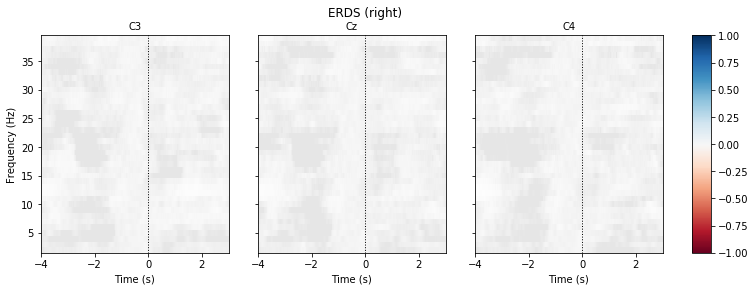

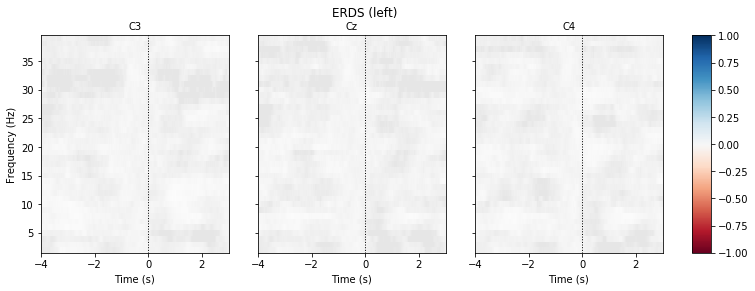

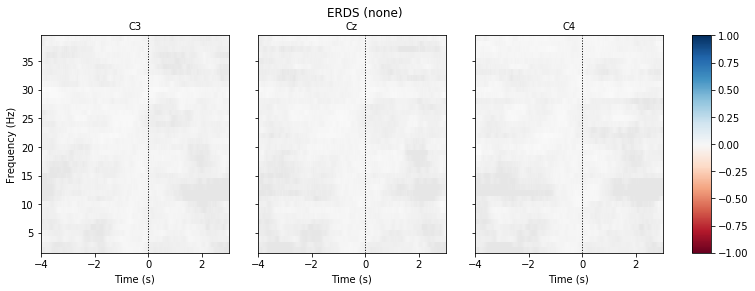

In [238]:
for event in ["right", "left", "none"]:
    # select desired epochs for visualization
    tfr_ev = tfr[event]
    fig, axes = plt.subplots(1, 4, figsize=(12, 4),
                             gridspec_kw={"width_ratios": [10, 10, 10, 1]})
    for ch, ax in enumerate(axes[:-1]):  # for each channel
        # positive clusters
        _, c1, p1, _ = pcluster_test(tfr_ev.data[:, ch, ...], tail=1, **kwargs)
        # negative clusters
        _, c2, p2, _ = pcluster_test(tfr_ev.data[:, ch, ...], tail=-1,
                                     **kwargs)

        # note that we keep clusters with p <= 0.05 from the combined clusters
        # of two independent tests; in this example, we do not correct for
        # these two comparisons
        c = np.stack(c1 + c2, axis=2)  # combined clusters
        p = np.concatenate((p1, p2))  # combined p-values
        mask = 0*c[..., p <= 1].any(axis=-1)

        # plot TFR (ERDS map with masking)
        tfr_ev.average().plot([ch], vmin=vmin, vmax=vmax, cmap=(cmap, False),
                              axes=ax, colorbar=False, show=False, mask=mask,
                              mask_style="mask")

        ax.set_title(epochs.ch_names[ch], fontsize=10)
        ax.axvline(0, linewidth=1, color="black", linestyle=":")  # event
        if not ax.is_first_col():
            ax.set_ylabel("")
            ax.set_yticklabels("")
    fig.colorbar(axes[0].images[-1], cax=axes[-1])
    fig.suptitle("ERDS ({})".format(event))
    fig.show()

Визуализировать для как можно большего количества электродов

# Prepare EOG and ECG removal

http://mne.tools/mne-biomag-group-demo/auto_examples/demos/plot_ica.html

# Draw maps depending on location

In [ ]:
! ls /home/noomkcalb/Документы/neuroscience/right-left/venv/lib/python3.5/site-packages/mne/channels/data/montages

In [ ]:
eeg.rename_channels({
    c: c.replace(".", "") 
    for c in eeg.ch_names
})

In [ ]:
eeg = eeg.set_montage("biosemi64")

In [ ]:
eeg.plot_sensors(kind='3d', ch_type='eeg', ch_groups='position')
plt.show()

In [ ]:
epochs = mne.Epochs(
    eeg, 
    events, 
    event_id={
        "none": 1,
        "left": 2,
        "right": 3
    },
)

In [ ]:
def plot_evoked_topo(event):
    evoked = epochs[event].average()
    times = [-0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5]
    evoked.plot_topomap(times, ch_type='eeg', time_unit='s')

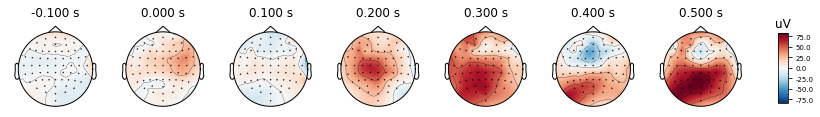

In [28]:
plot_evoked_topo("left")

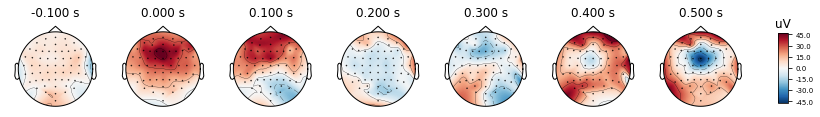

In [29]:
plot_evoked_topo("right")

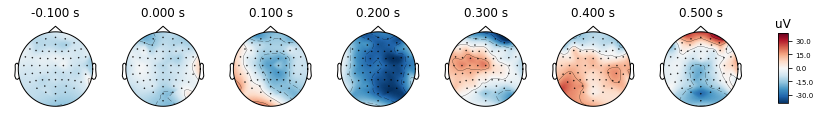

In [30]:
plot_evoked_topo("none")